In [1]:
# @Date    : Nov-08-20 00:29
# @Author  : Kelly Hwong (dianhuangkan@gmail.com)
# @RefLink : https://keras.io/api/applications/
# @RefLink : https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from utils.data_utils import data_generators
import matplotlib.pyplot as plt

In [2]:
# data path
competition_name = "dogs-vs-cats-redux-kernels-edition"
data_dir = os.path.expanduser(f"~/.kaggle/competitions/{competition_name}")

# Input parameters
IMAGE_WIDTH = IMAGE_HEIGHT = 128
image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
num_classes = 2

# tmp
batch_size = 32

## Data loader

In [3]:
train_generator, validation_generator = data_generators(
        data_dir, target_size=image_size, batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [4]:
x, y = next(train_generator)

In [6]:
x.shape

(32, 128, 128, 3)

In [9]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [8]:
y.shape
print(y)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [28]:
input_ = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(input_, tf.float32)
x = preprocess_input(x)
extractor = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape, classes=num_classes)
x = extractor(x)
classifier = keras.Sequential([
    keras.Input((4, 4, 2048)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(num_classes, activation='softmax')], 
    name="classifier")
x = classifier(x)
model = tf.keras.Model(inputs=[input_], outputs=[x], name="model")
# model = keras.Sequential([extractor, classifier], name="model")

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_Cast_1 (TensorFl [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, None, None, 3)]   0         
_________________________________________________________________
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
classifier (Sequential)      (None, 2)                 4098      
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
____________________________________________

sample name: cat.11069.jpg


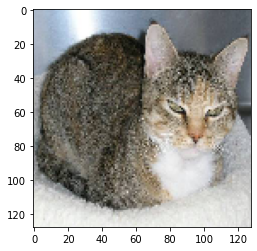

In [9]:
# Show sample image
sample = np.random.choice(filenames)
sample = "cat.11069.jpg"
print(f"sample name: {sample}")
img = image.load_img(os.path.join(data_dir, "train", sample), target_size=input_shape)
plt.imshow(img)
plt.show()

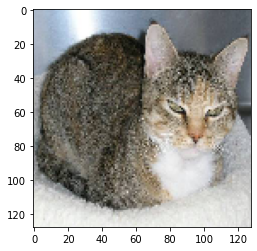

In [25]:

x = image.img_to_array(img)
plt.imshow(x.astype(int))

In [11]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # form a batch
x = preprocess_input(x) # mode, caffe BGR

In [12]:
x.shape

(1, 128, 128, 3)

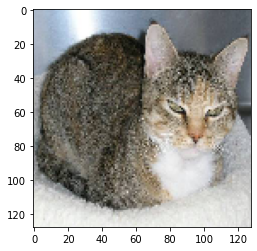

In [13]:
mean = [103.939, 116.779, 123.68]
_x = x[0]
_x[..., 0] += mean[0]
_x[..., 1] += mean[1]
_x[..., 2] += mean[2]
_x = _x[...,::-1] # BGR to RGB
plt.imshow(_x.astype(int))

In [14]:
model.predict(x)

array([[1.0000000e+00, 5.4328863e-15]], dtype=float32)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall, Precision, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, AUC
metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    TruePositives(name='tp'),  # thresholds=0.5
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    # AUC0(name='auc_good_0'),  # 以 good 为 positive 的 AUC
    AUC(name='auc_bad_1')  # 以 bad 为 positive 的 AUC
]
model.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=metrics)

In [16]:
epochs = 3
history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        # callbacks=callbacks,
        verbose=1
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 157 steps
Epoch 1/3
130/625 [=====>........................] - ETA: 4:29 - loss: 0.6730 - recall: 0.6732 - precision: 0.6732 - tp: 2779.0000 - fp: 1349.0000 - tn: 2779.0000 - fn: 1349.0000 - accuracy: 0.6732 - auc_bad_1: 0.7204

KeyboardInterrupt: 

In [30]:
train_generator.class_indices

{'cat': 0, 'dog': 1}